# Speech Commands
In this Practical work you will be given voice commands recorded by devices such as assistants. The task is to recognize the voice command from the audio signal. The dataset is stored as waveforms, each one being a 1 second file containing one voice command. The first step will be to extract speech features, either Melfilterbanks or MFCC. Then you will train different type of classifiers to recognize the spoken voice command from the speech features. These classifiers are a Logistic Regression and a Neural Network.

### Replace the path in the shell below by the one that contains the dataset

In [1]:
import numpy as np
import spectral
import librosa
import IPython
import os
import scipy.io.wavfile as wav
import sklearn
from sklearn.neural_network import MLPClassifier

# Import functions to store training results
import csv
from datetime import datetime
from log import _check_log_directory,_initialise_model_log, _read_model_log
log_dir = '/Users/sebastienohleyer/Documents/ENS MVA/MVA_2018_SL/TD_#1/log'
log_name = (datetime.now().strftime('%d-%m-%Y_%H-%M-%S'))
log_filepath = os.path.join(log_dir,log_name,'model_results.csv')
_check_log_directory(os.path.join(log_dir,log_name))
_initialise_model_log(log_filepath)

Attempting to make log directory at /Users/sebastienohleyer/Documents/ENS MVA/MVA_2018_SL/TD_#1/log/04-02-2018_19-14-37


In [2]:
os.chdir('./speech_commands_v0.01')
import time
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(777)

These functions are just utilities that will help facilitate features extraction. Feel free to modify them if you need to, but it is not required.

In [3]:
def txt2list(filename):
    lines_list = []
    with open(filename, 'r') as txt:
        for line in txt:
            lines_list.append(line.rstrip('\n'))
    return lines_list

def transform_wavs(wavs_list, feature_func):
    features = []
    for wav in wavs_list:
        features.append(feature_func.transform(wav).flatten())
    return features

def pad(features):
    max_len = 0
    padded_features =[]
    for feat_file in features:
        max_len = max(max_len, feat_file.shape[0])
    for feat_file in features:
        pad_size = max_len - feat_file.shape[0]
        left_pad = pad_size / 2
        right_pad = pad_size - left_pad
        padded_features.append(np.pad(feat_file, ((left_pad, right_pad),), 'constant', constant_values=(0, 0)))
    return padded_features

Load the data. In this practical work, you are expected to train your models on the training set and evaluate them on the validation set. When you will get your final best model, report the results on the test set.

In [4]:
## Loading data
label_set = ['go', 'yes', 'sheila', 'right', 'three', 'cat', 'one', 'on', 'bed', 'nine']
nb_ex_per_class = 300
# Valid set
valid_list = txt2list('validation_list.txt')
# Test set
test_list = txt2list('testing_list.txt')

In [5]:
# Iterate over files
train_wavs = []
train_labels = []

valid_wavs = []
valid_labels = []

test_wavs = []
test_labels = []

for root, dirs, files in os.walk("."):
    if root == './_background_noise_':
        continue
    for filename in files:
        if not filename.endswith('.wav'):
            continue
        command = root.lstrip('./')
        if command not in label_set:
            continue
        else:
            label = label_set.index(command)
        full_name = os.path.join(root.lstrip('./'), filename)
        fs, waveform = wav.read(full_name)
        if full_name in valid_list and len(valid_labels) < 1000:
            valid_wavs.append(waveform)
            valid_labels.append(label)
        elif full_name in test_list and len(test_labels) < 1000:
            test_wavs.append(waveform)
            test_labels.append(label)
        elif train_labels.count(label) < nb_ex_per_class:
            train_wavs.append(waveform)
            train_labels.append(label)

add_noise=False
if add_noise is True:
    for root, dirs, files in os.walk("./_background_noise_"):
        for filename in files:
            if not filename.endswith('.wav'):
                continue
            full_name = os.path.join(root.lstrip('./'), filename)
            fs, waveform = wav.read(full_name)
            train_wavs.append(waveform)
            train_labels.append(label)

# Print data statistics      
print "Train files: " + str(len(train_wavs))
print "Valid files: " + str(len(valid_wavs))
print "Test files: " + str(len(test_wavs))

Train files: 3000
Valid files: 1000
Test files: 1000


In [6]:
train_wavs_array = np.array(train_wavs)
valid_wavs_array = np.array(valid_wavs)
test_wavs_array = np.array(test_wavs)

In [7]:
from tqdm import tqdm

normalize = False

def normalize_speech_features(wavs):
    normalize_wavs_array = np.zeros((len(wavs), 16000))
    for idx, wav in tqdm(enumerate(wavs)):
        for i in range(len(wav)):
            normalize_wavs_array[idx,i] = wav[i]
    feat_mean = np.mean(normalize_wavs_array, axis=0, keepdims=True)
    feat_std = np.std(normalize_wavs_array, axis=0, keepdims=True)
    return normalize_wavs_array, feat_mean, feat_std

if normalize is True:
    normalize_train_wavs_array, feat_mean, feat_std = normalize_speech_features(train_wavs)
    train_wavs_array = np.divide(np.subtract(normalize_train_wavs_array, feat_mean), feat_std)
    
    normalize_valid_wavs_array,_,_ = normalize_speech_features(valid_wavs)
    valid_wavs_array = np.divide(np.subtract(normalize_valid_wavs_array, feat_mean), feat_std)

    normalize_test_wavs_array,_,_ = normalize_speech_features(test_wavs)
    test_wavs_array = np.divide(np.subtract(normalize_test_wavs_array, feat_mean), feat_std)

The following cells create feature functions that have a .transform method that takes a waveform as input. You should not change the framerate parameter (the dataset is sampled at 16kHz).
The other parameters are the following:
* nfilt = number of mel-filters to average spectrograms
* ncep = number of cepstral coefficients to use for MFCCs
* do_dct = True to compute MFCC (otherwise mel-filterbanks are the output)
* lowerf = lowest frequency spanned by the filters (and that will be taken into account by the features)
* higherf = highest frequency spanned by the filters
* alpha = parameter use for the pre-emphasis
* frate = number of frames per second (1/frate is the stride of the windows in seconds)
* wlen = length of windows in seconds
* nfft = number of frequency bins used to compute the spectrogram
* compression = the final compression performed on the mel-filterbanks (before DCT if you put do_dct=True)
* do_deltas = compute the first derivatives of MFCC
* do_deltasdeltas = compute the second derivatives of MFCC

In [8]:
framerate = 16000

# Mel-filterbanks function

In [9]:
melfbanks = spectral.Spectral(nfilt=26,
                    ncep=0,
                    do_dct=False,
                    lowerf=0,
                    upperf=8000,
                    alpha=0.97,
                    fs=framerate,
                    frate=80,
                    wlen=0.025,
                    nfft=512,
                    compression='log',
                    do_deltas=False,
                    do_deltasdeltas=False)

# MFCC function

In [10]:
mfcc = spectral.Spectral(nfilt=26,
                    ncep=13,
                    do_dct=True,
                    lowerf=0,
                    upperf=8000,
                    alpha=0.97,
                    fs=framerate,
                    frate=80,
                    wlen=0.025,
                    nfft=512,
                    compression='log',
                    do_deltas=True,
                    do_deltasdeltas=True) 

# The following cell generates the features for train, valid and test from the waveforms

In [11]:
# Choose the feature function
feature_function = mfcc
feature_function_name = 'mfcc'

start = time.time()
train_feats = np.asarray(pad(transform_wavs(train_wavs, feature_function)))
valid_feats = np.asarray(pad(transform_wavs(valid_wavs, feature_function)))
test_feats = np.asarray(pad(transform_wavs(test_wavs, feature_function)))
end = time.time()
feature_function_training_time = end-start
print "Time to output features: " + str(feature_function_training_time)

Time to output features: 45.5948271751


In [12]:
# Next cell trains a logistic regression on the speech features

In [13]:
#Logistic regression

logreg = sklearn.linear_model.LogisticRegression(verbose=1, tol=1e-4, random_state=777, C=1.5)

start = time.time()
logreg.fit(train_feats, train_labels)
end = time.time()
log_reg_training_time = end-start
print "Training time: " + str(log_reg_training_time)

[LibLinear]Training time: 125.484946012


# You can now evaluate it on the validation set

In [14]:
accuracy = 100*logreg.score(valid_feats, valid_labels)
print "Accuracy on valid set " + str(accuracy) + "%"

# write model results
with open(log_filepath, 'a') as fp:
    a = csv.writer(fp, delimiter=',')
    data = [[datetime.now().strftime('%d-%m-%Y_%H-%M-%S'), 'logistic_reg', accuracy,
             feature_function_name, normalize, feature_function.config, feature_function_training_time, 
             logreg.get_params(), log_reg_training_time]]
    a.writerows(data)

Accuracy on valid set 45.2%


In [15]:
neural_net = MLPClassifier(hidden_layer_sizes=(500,), validation_fraction = 0.2, early_stopping = False, activation='relu',
                                   verbose = True, random_state = 777, learning_rate='adaptive',
                                   learning_rate_init=0.001, solver='adam')

start = time.time()
neural_net.fit(train_feats, train_labels)
end = time.time()
neural_net_training_time = end-start
print "Training time: " + str(neural_net_training_time)

Iteration 1, loss = 3.96782215
Iteration 2, loss = 1.92127734
Iteration 3, loss = 1.46959591
Iteration 4, loss = 1.26409574
Iteration 5, loss = 1.10757781
Iteration 6, loss = 0.98585579
Iteration 7, loss = 0.87524553
Iteration 8, loss = 0.79025072
Iteration 9, loss = 0.73409343
Iteration 10, loss = 0.69020332
Iteration 11, loss = 0.60158086
Iteration 12, loss = 0.56173960
Iteration 13, loss = 0.53831629
Iteration 14, loss = 0.48612038
Iteration 15, loss = 0.44876829
Iteration 16, loss = 0.41179742
Iteration 17, loss = 0.36705770
Iteration 18, loss = 0.33673655
Iteration 19, loss = 0.30135552
Iteration 20, loss = 0.27962213
Iteration 21, loss = 0.25089197
Iteration 22, loss = 0.22732887
Iteration 23, loss = 0.20896266
Iteration 24, loss = 0.19524442
Iteration 25, loss = 0.18805744
Iteration 26, loss = 0.18004144
Iteration 27, loss = 0.15298200
Iteration 28, loss = 0.14029771
Iteration 29, loss = 0.12740921
Iteration 30, loss = 0.12669611
Iteration 31, loss = 0.11549359
Iteration 32, los

# Evaluate it on the valid set

In [16]:
accuracy = 100*neural_net.score(valid_feats, valid_labels)
print "Accuracy on valid set " + str(accuracy) + "%"

# write model results
with open(log_filepath, 'a') as fp:
    a = csv.writer(fp, delimiter=',')
    data = [[datetime.now().strftime('%d-%m-%Y_%H-%M-%S'), 'neural_net', accuracy,
             feature_function_name, normalize, feature_function.config, feature_function_training_time, 
             neural_net.get_params(), neural_net_training_time]]
    a.writerows(data)

Accuracy on valid set 76.2%


# Listen to a random waveform from the training set

In [17]:
random_idx = random.randint(0, len(valid_wavs))
random_wav = valid_wavs[random_idx]
IPython.display.Audio(random_wav, rate=16000)

# Visualize mel-filterbanks and MFCC

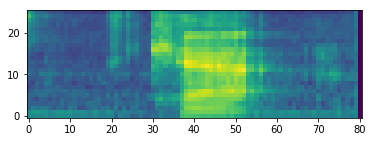

In [18]:
plt.imshow(melfbanks.transform(random_wav).transpose())
plt.gca().invert_yaxis()

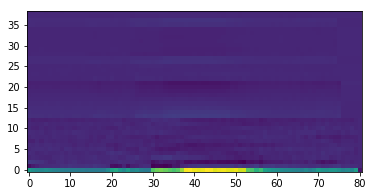

In [19]:
plt.imshow(mfcc.transform(random_wav).transpose())
plt.gca().invert_yaxis()

# See what your classifier has predicted

In [20]:
print label_set[neural_net.predict(valid_feats[random_idx][np.newaxis])[0]]

cat


# What you are expected to do in this TP
This notebook contains the different blocks that allow you to train speech commands recognizers. The results provided with the features and classifiers above are far from optimal.

You are expected to explore various ways to improve their performance. Here are the main things to try:
* The parameters of the speech features such as the min/max frequency or window size are poorly chosen, look inside the resources mentioned in the class to find the best parameters for mel-filterbanks and MFCC.
* The logistic regression can be regularized in different ways (by controlling the C parameter) and you can try to find the best one
* The neural net proposed is a shallow neural net, far from the best you can train. You should try bigger, deeper architectures, different types of regularization, activation functions, learning rate and so on
* A standard way of improving generalization is to do mean-variance normalization on your data set. This is done by computing the mean and variance of each feature dimension on the entire training set, and then use it to normalize train, valid and test set
* The dataset provides noises samples, either artificial (pink, white noise) or real (dishes, bike) in the folder _background_noise. You can try augmenting your dataset by adding noise to the waveforms before computing the features
* The model is only trained on 300 examples per class, if your hardware allows it, try training on more examples
* Feel free to also experiment with different classifiers

You should find the best model by comparing validation accuracies. After you find your best model, finally test it on the test set and print the result. Comment on the results (best model, best features, classes that are the most difficult to recognize). The grade will not depend on the performance of the final system, but on how you experimented, tried different ideas, and comment on them.

Write your comments in Markdown cells, and send the ipython notebook as your assignment. Good luck!

[Documentation for logistic regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

[Documentation for neural network](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

# Results and comments

We compared the accuracy obtained with Mel-fitlerbanks and MFCC using different classifiers and we present our results for both features.

## Mel-filterbanks

#### Parameters
We perform a manual grid search to find the best parameters. Note that the framerate remains fixed at 16kHz and ncep, do_dct, do_deltas and dodeltadelta were not changed as they are exclusive parameters of the MFCC.
* nfilt: 26. We slightly increase the number of filter, as it gives better results.
* lowerf: 0. We decide to keep all the lower frequency, to have as much information as possible to compute features.
* upperf: 8000. As the sample rate is fixed at 16kHz, we set the upperf at framerate/2.
* alpha: 0.97. The preemphasis filter coefficient was increase.
* frate: 100. This parameter allow to handle the frame overlay during the acquisition. Typically, the overlay last approximately 100ms. A short computation with this frate gives 6ms. Is has to be chosen in adequation with the length of the window.
* wlen: 0.025. Window length is typically of 25ms. It is highly related to the typical duration of a phoneme (a few dozens ms).
* nfft: 512. We keep the standard value for nfft.
* compression: log. We keep the standard compression.

This set up return an accuracy of **41.0%** with the logitic regression with tol=0.001 and C=1.5.

Using the neural network, it was found better to slightly reduce de frate and fix it to 80. Using a pretty simple network: 500 hidden layer, Relu activation, Adam solver and tol=0.0001, we manage to outperform the logistic regression and obtain an accuracy of **57.1%**.

#### Influence of the feature normalization

As proposed in the TP expectations, we tried to perform a mean and variance feature normalization. The function `normalize_speech_features` provided above perform this normalization. Note that some features are not computed for some particular files. Hence we choose to set them at zero to compute the mean and the variance.

Unsuprisingly, the normalization does not have any impact on the accuracy obtained with logistic regression. Moreover, it increases the computation time to generate the features (from 45s to 60s) and the training time (from 80s to 90s). We observe the same phenomenon with the neural network. This is du to the nature of these classifiers which are not sensitive to features normalization.

#### Influence of noise addition

To increase performances, we tried a classic trick called data augmentation, by adding noisy samples to the dataset. However, it decreases the accuracy for both classifier and slow down the training.

## MFCC

#### Parameters

We proceed the same way for MFCC, but we add parameters relevant for this new feature. Note that for this feature too, the framerate is fixed at 16kHz as it depends on the signal sampling.
* nfilt: 26. Same remark as mel-filterbanks.
* ncep: 13. We choose the number of cepstrum to return in adequation with nfilt.
* do_dct: True. For MFCC, we need to perform DCT. It is one of the main difference between MFCC and mel-filterbanks.
* lowerf: 0. Same remark as mel-filterbanks.
* higherf: 8000. Same remark as mel-filterbanks.
* alpha: 0.97. Same remark as mel-filterbanks.
* frate: 80. Same remark as mel-filterbanks.
* wlen: 0.25. Same remark as mel-filterbanks.
* nfft: 512. Same remark as mel-filterbanks.
* compression: log. Same remark as mel-filterbanks.
* do_deltas: True. For this feature, we choose to augment our knowledge of the signal by computing the first derivative.
* do_deltasdeltas: True. Same reason as do_deltas for second derivatives.

These parameters choices gives an accuracy of **45.5%** with the logitic regression with tol=0.001 and C=1.5.

With the neural network, we achieve the best results of all features/classifiers combinations. Using the same network as above: 500 hidden layer, Relu activation, Adam solver and tol=0.0001, we achieve an accuracy of **76.2%**. This is the actual printed result on the notebook.

#### Influence of the feature normalization

Same remark as mel-filterbank.

#### Influence of noise addition

Same remark as mel-filterbank.

## Class predictions
After a few trials, we achieve our best results with MFCC and neural network as presented above. If needed, the details of each run is available on the GitHub fork: https://github.com/sohleyer/MVA_2018_SL/tree/master/TD_%231. Feel free to observe the results printed in a csv file, with all parameters and computation for features computation and model training.

We decide to pursue only with best parameters and models found (ie MFCC and neural network presented above).

#### Intra-class accuracy

To give us an idea of the difficulties encountered by our classifier, we compute intra-class accuracies.

In [23]:
for label in np.unique(np.array(valid_labels)):
    valid_class = valid_feats[np.array(valid_labels)==label]
    class_res = neural_net.score(valid_class, label*np.ones(len(valid_class)))
    print("Label "+ str(label_set[label])+": "+str(100*class_res))

Label go: 78.0769230769
Label cat: 80.9523809524
Label on: 77.2413793103
Label bed: 75.1269035533
Label nine: 70.8695652174


As we can see in the cell above, the classifier achieves best predictions for cat, go, on, bed but worst on nine. Remark that nine is the only word in the validation set with two syllables, maybe it can explain the difficulty to predict it well.

Let us now observe which was the wrong predictions for this label.

<function matplotlib.pyplot.show>

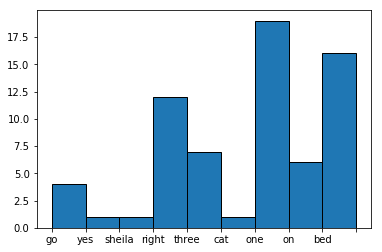

In [24]:
valid_nine = valid_feats[np.array(valid_labels)==9]
nine_res = neural_net.predict(valid_nine)
plt.hist(nine_res[nine_res!=9],bins=np.arange(0,10,1), ec='black'); 
plt.xticks( np.arange(0,10,1), [label_set[i] for i in np.arange(0,9,1)] ); plt.show

Something really interesting is that the label 'nine' is mostly confused with 'one' which are two word with close phonetic. It highlights the classifier troubles to distinguish two close words. Maybe these features are not discriminative enough for the classifier, the two points in the multi-dimensional space are too close. An idea could be to add more discriminative features to help the classifier or to change the classifier.

## Other classifiers

For a better understanding of the problem, we try two other classifiers from the sklearn library: the Random Forest and the Gradient Boosting. With the first one, we obtain some results quickly (less than 20s) but we did not manage to have an accuracy above 70% (maximum was **66.2%**). Concerning the Gradient Boosting, because of the material computational limitations we were not able to obtain results in a reasonable time (the training last more than 10min). That is why we decided to not present our results in details.

Similarly, we could not increase the number of training examples for hardware purpose and lack of time. 